# Telecom Churn Prediction


The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [3]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#!pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import RFE

#from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
#from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Importing libraries for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

from imblearn.pipeline import Pipeline

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from imblearn.over_sampling import SMOTE

#Others
import warnings
warnings.filterwarnings('ignore')
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)


##### Importing stats model
import statsmodels.api as sm

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

# 1. Data Read and Analysis

In [4]:
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [5]:
pd.set_option('display.max_columns', 500)

In [6]:
data.describe()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count  69999.000000    69999.0         69297.0         69297.0   
mean   34999.000000      109.0             0.0             0.0   
std    20207.115084        0.0             0.0             0.0   
min        0.000000      109.0             0.0             0.0   
25%    17499.500000      109.0             0.0             0.0   
50%    34999.000000      109.0             0.0             0.0   
75%    52498.500000      109.0             0.0             0.0   
max    69998.000000      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count         69297.0  69999.000000  69999.000000  69999.000000  67231.000000   
mean              0.0    283.134365    278.185912    278.858826    133.153275   
std               0.0    334.213918    344.366927    351.924315    299.963093   
min               0.0  -2258.709000  -1289.715000   -945.808000      0.000000   
25%               0.0     93.581000     86.714000     84.095000      7.410000   
50%               0.0    197.484000    191.588000    192.234000     34.110000   
75%               0.0    370.791000    365.369500    369.909000    119.390000   
max               0.0  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  67312.000000  66296.000000  67231.000000  67312.000000  66296.000000   
mean     133.894438    132.978257    198.874771    197.153383    196.543577   
std      311.277193    311.896596    316.818355    322.482226    324.089234   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.675000      6.410000     34.860000     32.240000     31.575000   
50%       32.280000     32.100000     96.480000     91.885000     91.800000   
75%      115.837500    115.060000    232.990000    227.630000    229.345000   
max     8157.780000  10752.560000   8362.360000   7043.980000  14007.340000   

       roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
count   67231.000000   67312.000000   66296.000000   67231.000000   
mean        9.765435       7.014568       7.004892      14.186457   
std        57.374429      55.960985      53.408135      73.469261   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max      2850.980000    4155.830000    4169.810000    3775.110000   

       roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count   67312.000000   66296.000000      67231.000000      67312.000000   
mean        9.842191       9.771783         46.904854         46.166503   
std        58.511894      64.618388        150.971758        154.739002   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          1.660000          1.650000   
50%         0.000000       0.000000         11.910000         11.580000   
75%         0.000000       0.000000         40.740000         39.760000   
max      2812.040000    5337.040000       6431.330000       7400.660000   

       loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
count      66296.000000      67231.000000      67312.000000      66296.000000   
mean          45.686109         93.238231         90.799240         91.121447   
std          153.716880        162.046699        153.852597        152.997805   
min            0.000000          0.000000          0.000000          0.000000   
25%            1.610000          9.920000         10.090000          9.830000   
50%           11.740000         41.030000         40.170000         40.350000   
75%           39.895000        110.430000        107.540000        109.245000   
max        10752.560000       4696

In [7]:
data = data.set_index('id')
data.head()

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
id                                                              
0         109             0.0             0.0             0.0   
1         109             0.0             0.0             0.0   
2         109             0.0             0.0             0.0   
3         109             0.0             0.0             0.0   
4         109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
id                                                                           
0             6/30/2014            7/31/2014            8/31/2014   31.277   
1             6/30/2014            7/31/2014            8/31/2014    0.000   
2             6/30/2014            7/31/2014            8/31/2014   60.806   
3             6/30/2014            7/31/2014            8/31/2014  156.362   
4             6/30/2014            7/31/2014            8/31/2014  240.708   

     arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
id                                                                          
0    87.009    7.527        48.58       124.38         1.29         32.24   
1   122.787   42.953         0.00         0.00         0.00          0.00   
2   103.176    0.000         0.53        15.93         0.00         53.99   
3   205.260  111.095         7.26        16.01         0.00         68.76   
4   128.191  101.565        21.28         4.83         6.13         56.99   

    offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
id                                                                            
0          96.68          2.33           0.00            0.0            0.0   
1          25.99         30.89           0.00            0.0            0.0   
2          82.05          0.00           0.00            0.0            0.0   
3          78.48         50.23           0.00            0.0            0.0   
4          38.11          9.63          53.64            0.0            0.0   

    roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
id                                                                  
0            0.00            0.0           0.00              2.23   
1            0.00            0.0           0.00              0.00   
2            0.00            0.0           0.00              0.53   
3            0.00            0.0           1.63              6.99   
4           15.73            0.0           0.00             10.16   

    loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
id                                                                           
0               0.00              0.28              5.29             16.04   
1               0.00              0.00              0.00              0.00   
2              12.98              0.00             24.11              0.00   
3               3.94              0.00             37.91             44.89   
4               4.83              6.13             36.74             19.88   

    loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
id                                                                           
0               2.33              0.00              0.00              0.00   
1               0.00              0.00              0.00              0.00   
2               0.00              0.00              0.00              0.00   
3              23.63              0.00              0.00              0.00   
4               4.61             11.99              1.23              5.01   

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
id                                                                       
0               0.00              0.00              0.00          7.53   
1               0.00             22.01             29.79          0.00   
2               2.14             

## 1.1 Check for Missing % values in columns

In [8]:
# Cheking percent of missing values in columns
df_missing_columns = (round(((data.isnull().sum()/len(data.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
df_missing_columns

null
count_rech_2g_6           74.9
arpu_2g_6                 74.9
night_pck_user_6          74.9
date_of_last_rech_data_6  74.9
total_rech_data_6         74.9
...                        ...
vol_2g_mb_6                0.0
vol_2g_mb_7                0.0
vol_2g_mb_8                0.0
vol_3g_mb_6                0.0
churn_probability          0.0

[171 rows x 1 columns]

### We have observed that Missing % 73.69. Hence we can set the threshold as 70%

In [9]:
# List the columns having more than 70% missing values
col_list_missing_70 = list(df_missing_columns.index[df_missing_columns['null'] > 70])
col_list_missing_70

['count_rech_2g_6',
 'arpu_2g_6',
 'night_pck_user_6',
 'date_of_last_rech_data_6',
 'total_rech_data_6',
 'av_rech_amt_data_6',
 'max_rech_data_6',
 'count_rech_3g_6',
 'arpu_3g_6',
 'fb_user_6',
 'arpu_3g_7',
 'night_pck_user_7',
 'date_of_last_rech_data_7',
 'total_rech_data_7',
 'max_rech_data_7',
 'fb_user_7',
 'av_rech_amt_data_7',
 'count_rech_2g_7',
 'count_rech_3g_7',
 'arpu_2g_7',
 'arpu_2g_8',
 'night_pck_user_8',
 'arpu_3g_8',
 'max_rech_data_8',
 'av_rech_amt_data_8',
 'date_of_last_rech_data_8',
 'fb_user_8',
 'count_rech_3g_8',
 'total_rech_data_8',
 'count_rech_2g_8']

In [10]:
#Drop the columns having > 70 missing data
data = data.drop(col_list_missing_70, axis=1)

In [11]:
data.shape

(69999, 141)

In [12]:
# Dropping all date columns for now as this looks less contributing to our usecase
date_cols = [k for k in data.columns.to_list() if 'date' in k]
print(date_cols)

['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']


In [13]:
data = data.drop(date_cols, axis=1)
data.shape

(69999, 135)

## 1.2 Check Aggregation Details of values

In [14]:
# checking aggregrate details of value count of each colum
# Check which columns having same value in each column
data.agg(['count','nunique','unique'])

circle_id loc_og_t2o_mou std_og_t2o_mou loc_ic_t2o_mou  \
count       69999          69297          69297          69297   
nunique         1              1              1              1   
unique      [109]     [0.0, nan]     [0.0, nan]     [0.0, nan]   

                                                    arpu_6  \
count                                                69999   
nunique                                              61615   
unique   [31.277, 0.0, 60.806, 156.362, 240.708, 86.193...   

                                                    arpu_7  \
count                                                69999   
nunique                                              61425   
unique   [87.009, 122.787, 103.176, 205.26, 128.191, 83...   

                                                    arpu_8  \
count                                                69999   
nunique                                              60194   
unique   [7.527, 42.953, 0.0, 111.095, 101.565, 88.462,...   

                                               onnet_mou_6  \
count                                                67231   
nunique                                              20057   
unique   [48.58, 0.0, 0.53, 7.26, 21.28, 1.39, 38.81, 2...   

                                               onnet_mou_7  \
count                                                67312   
nunique                                              20076   
unique   [124.38, 0.0, 15.93, 16.01, 4.83, 1.78, 40.56,...   

                                               onnet_mou_8  \
count                                                66296   
nunique                                              19725   
unique   [1.29, 0.0, 6.13, 0.45, 19.61, 53.38, 177.36, ...   

                                              offnet_mou_6  \
count                                                67231   
nunique                                              26254   
unique   [32.24, 0.0, 53.99, 68.76, 56.99, 17.14, 31.63...   

                                              offnet_mou_7  \
count                                                67312   
nunique                                              26139   
unique   [96.68, 25.99, 82.05, 78.48, 38.11, 24.26, 54....   

                                              offnet_mou_8  \
count                                                66296   
nunique                                              25995   
unique   [2.33, 30.89, 0.0, 50.23, 9.63, 3.44, 5.69, 21...   

                                             roam_ic_mou_6  \
count                                                67231   
nunique                                               5306   
unique   [0.0, 53.64, 28.26, 18.56, 28.24, 12.58, nan, ...   

                                             roam_ic_mou_7  \
count                                                67312   
nunique                                               4240   
unique   [0.0, 11.31, 7.23, 3.4, nan, 0.88, 149.04, 43....   

                                             roam_ic_mou_8  \
count                                                66296   
nunique                                               4252   
unique   [0.0, 47.81, 3.46, nan, 0.76, 7.08, 7.26, 69.8...   

                                             roam_og_mou_6  \
count                                                67231   
nunique                                               6568   
unique   [0.0, 15.73, 47.81, 20.3, 45.31, 16.73, nan, 1...   

                                             roam_og_mou_7  \
count                                                67312   
nunique                                               5305   
unique   [0.0, 50.88, 32.28, 3.99, nan, 0.16, 1.15, 388...   

                                             roam_og_mou_8  \
count                                                66296   
nunique                                               5215   
unique   [0.0, 1.63, 21.74, 8.83, nan, 178.34, 26.38, 2...   

        

In [15]:
#Drop columns having 90% same data

total_records = data.shape[0]
total_records

ninty_percent = total_records*0.90 #69999 is the total number of rows
ninty_percent

dropCols = [] 
for i in data.columns :
    if data[i].value_counts().max() >= ninty_percent:
        dropCols.append(i)
print(dropCols)

['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'og_others_7', 'og_others_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8']


In [16]:
data = data.drop(dropCols, axis=1)
data.shape

(69999, 111)

In [17]:
# Cheking again percent of missing values in columns
(round(((data.isnull().sum()/len(data.index))*100),2).to_frame('null')).sort_values('null', ascending=False)

null
std_og_mou_8       5.29
std_ic_t2m_mou_8   5.29
std_og_t2m_mou_8   5.29
spl_og_mou_8       5.29
std_og_t2t_mou_8   5.29
...                 ...
total_rech_num_8   0.00
total_rech_amt_6   0.00
total_rech_amt_7   0.00
total_rech_amt_8   0.00
churn_probability  0.00

[111 rows x 1 columns]

<Axes: >

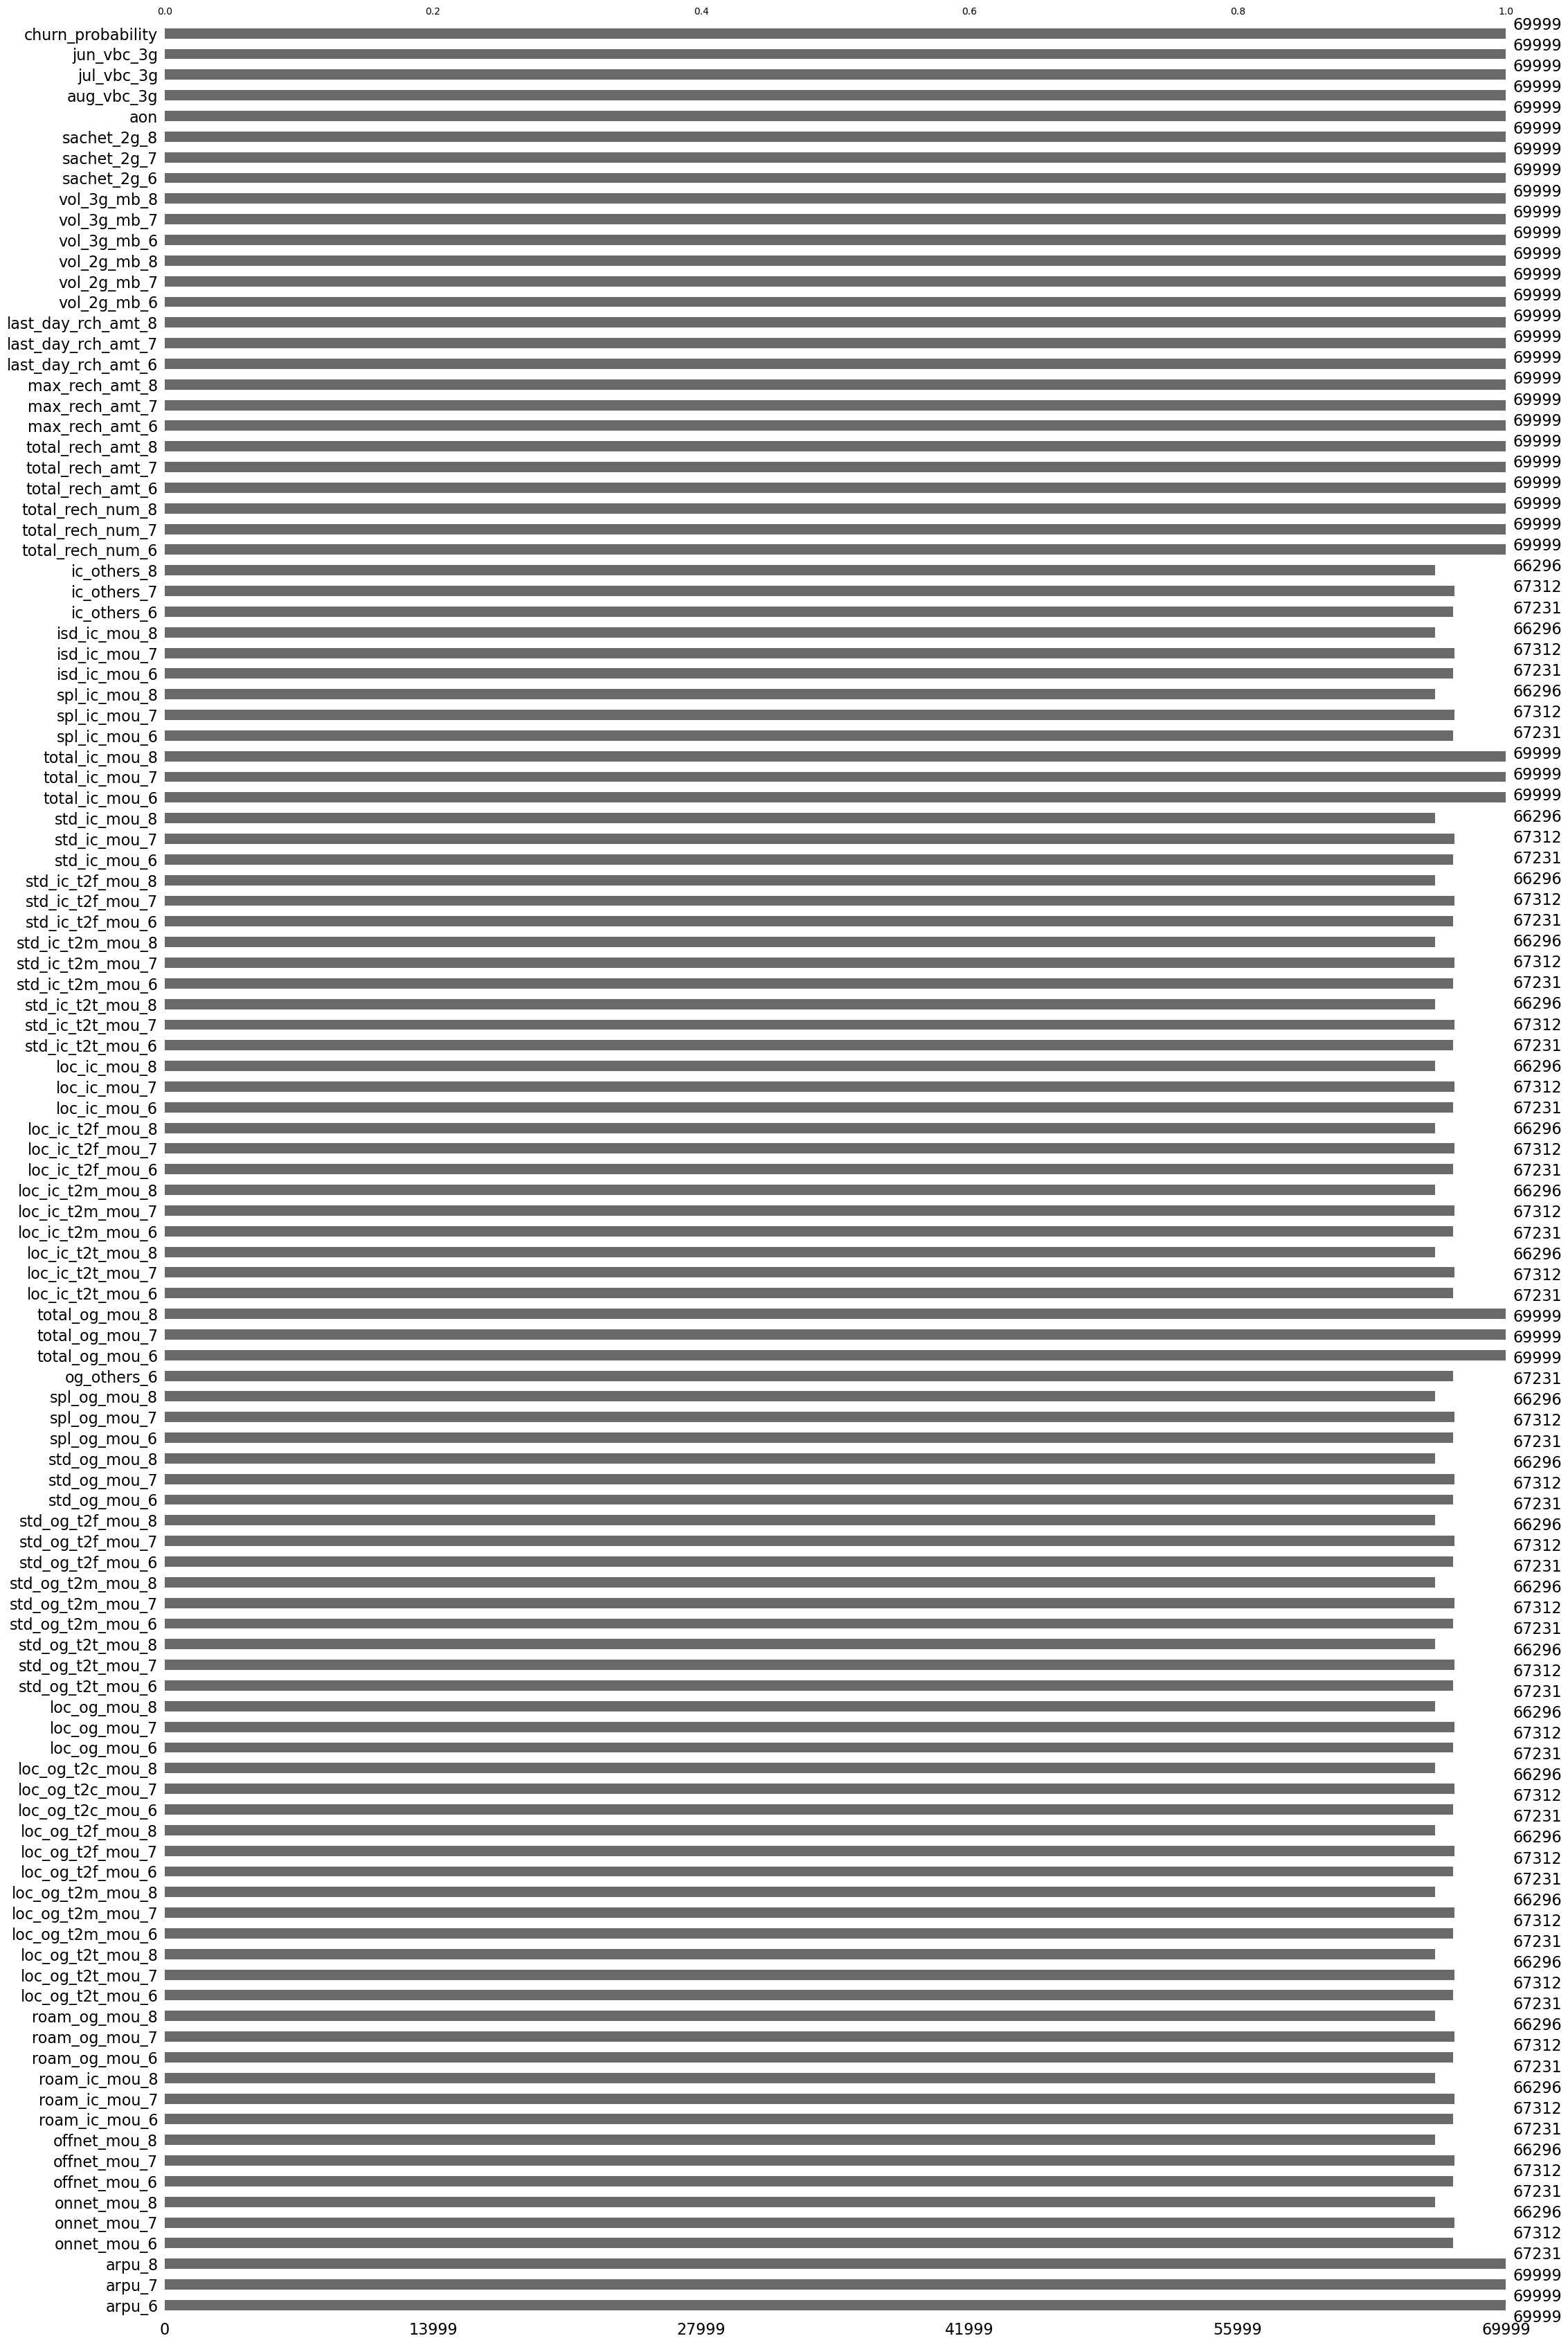

In [18]:
# Visualize the data in msno bar
msno.bar(data)

## 1.3 Check Missing Row Details > 50%

In [19]:
# Count the rows having more than 50% missing values
data_missing_rows_50 = data[(data.isnull().sum(axis=1)) > (len(data.columns)//2)]
data_missing_rows_50.shape

(758, 111)

In [20]:
# Deleting the rows having more than 50% missing values
data = data.drop(data_missing_rows_50.index)
data.shape

(69241, 111)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69241 entries, 0 to 69998
Columns: 111 entries, arpu_6 to churn_probability
dtypes: float64(94), int64(17)
memory usage: 59.2 MB


In [22]:
print(list(data.columns))

['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', '

In [23]:
#data[['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8']].describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])

In [24]:
data.describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])

arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  69241.000000  69241.000000  69241.000000  67231.000000  67312.000000   
mean     284.152508    279.943967    280.734946    133.153275    133.894438   
std      334.890697    345.233379    352.814151    299.963093    311.277193   
min    -2258.709000  -1289.715000   -945.808000      0.000000      0.000000   
1%         0.000000      0.000000      0.000000      0.000000      0.000000   
10%       33.580000     31.859000     21.412000      0.260000      0.150000   
25%       94.256000     87.927000     85.726000      7.410000      6.675000   
50%      198.070000    193.194000    193.781000     34.110000     32.280000   
75%      371.572000    367.182000    371.862000    119.390000    115.837500   
90%      621.184000    618.106000    617.237000    345.080000    347.908000   
95%      834.794000    826.339000    831.224000    617.185000    628.437500   
99%     1402.668800   1418.494000   1448.389400   1447.098000   1478.540900   
max    27731.088000  35145.834000  33543.624000   7376.710000   8157.780000   

        onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count  66296.000000  67231.000000  67312.000000  66296.000000   67231.000000   
mean     132.978257    198.874771    197.153383    196.543577       9.765435   
std      311.896596    316.818355    322.482226    324.089234      57.374429   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
1%         0.000000      0.000000      0.000000      0.000000       0.000000   
10%        0.000000      7.260000      6.431000      5.690000       0.000000   
25%        6.410000     34.860000     32.240000     31.575000       0.000000   
50%       32.100000     96.480000     91.885000     91.800000       0.000000   
75%      115.060000    232.990000    227.630000    229.345000       0.000000   
90%      343.695000    482.030000    482.071000    486.980000      11.950000   
95%      620.240000    735.985000    747.558000    738.017500      41.350000   
99%     1472.480500   1546.471000   1545.104000   1522.474000     219.649000   
max    10752.560000   8362.360000   7043.980000  14007.340000    2850.980000   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count   67312.000000   66296.000000   67231.000000   67312.000000   
mean        7.014568       7.004892      14.186457       9.842191   
std        55.960985      53.408135      73.469261      58.511894   
min         0.000000       0.000000       0.000000       0.000000   
1%          0.000000       0.000000       0.000000       0.000000   
10%         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
90%         5.039000       5.210000      22.710000       9.900000   
95%        23.199000      23.990000      69.455000      42.599000   
99%       153.006700     159.714000     290.851000     221.866800   
max      4155.830000    4169.810000    3775.110000    2812.040000   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count   66296.000000      67231.000000      67312.000000      66296.000000   
mean        9.771783         46.904854         46.166503         45.686109   
std        64.618388        150.971758        154.739002        153.716880   
min         0.000000          0.000000          0.000000          0.000000   
1%          0.000000          0.000000          0.000000          0.000000   
10%         0.000000          0.000000          0.000000          0.000000   
25%         0.000000          1.660000          1.650000          1.610000   
50%         0.000000         11.910000         11.580000         11.740000   
75%         0.000000         40.740000         39.760000         39.895000   
90%         9.270000        104.510000

In [25]:
# Cheking Again percent of missing values in columns
df_missing_columns = (round(((data.isnull().sum()/len(data.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
df_missing_columns.sort_values('null', ascending=False)

null
std_og_mou_8       4.25
std_og_t2f_mou_8   4.25
std_ic_t2m_mou_8   4.25
roam_og_mou_8      4.25
offnet_mou_8       4.25
...                 ...
sachet_2g_7        0.00
aon                0.00
aug_vbc_3g         0.00
max_rech_amt_8     0.00
churn_probability  0.00

[111 rows x 1 columns]

In [26]:
### Now we handle these missing data with Impute Techniques later

In [27]:
data.shape

(69241, 111)

# 2. Train test split

In [28]:
# Splitting data into train and test set 80:20
train_data, test_data = train_test_split(data, train_size=0.8, test_size=0.2, random_state=42)


In [29]:
print('Train Data shape :',train_data.shape)
print('Test Data shape :',test_data.shape)

Train Data shape : (55392, 111)
Test Data shape : (13849, 111)


# 3. EDA on Train Data

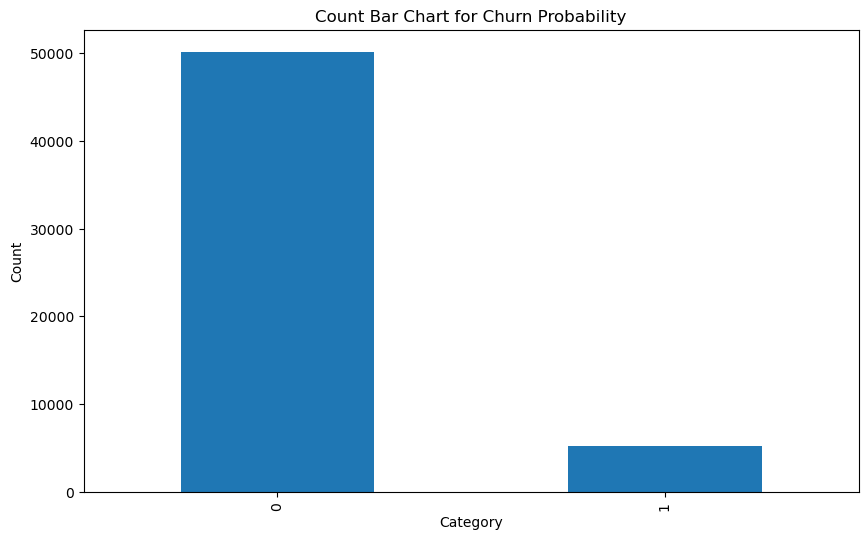

In [30]:
churn_probability_counts = train_data['churn_probability'].value_counts()
plt.figure(figsize=(10, 6))
churn_probability_counts.plot(kind='bar')
plt.title('Count Bar Chart for Churn Probability')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

#### Observed Data Imbalance in Chrun Probability. 

In [31]:
# Derive columns for Further Analysis

In [32]:
#Deriving new column decrease_mou
#This column indicates whether the minutes of usage of the customer has decreased.

train_data['total_mou_6'] = (train_data['total_og_mou_6'] + train_data['total_ic_mou_6'])
train_data['avg_mou_7_8'] = (train_data['total_og_mou_7'] + train_data['total_og_mou_8'] + train_data['total_ic_mou_7'] + train_data['total_ic_mou_8'])/2
train_data['diff_mou'] = train_data['avg_mou_7_8'] - train_data['total_mou_6']
train_data['decrease_mou'] = np.where((train_data['diff_mou'] < 0), 1, 0)

In [33]:
# Deriving new column decrease_rech_num
# This column indicates whether the number of recharge of the customer has decreased.

train_data['avg_rech_num_7_8'] = (train_data['total_rech_num_7'] + train_data['total_rech_num_8'])/2
train_data['diff_rech_num'] = train_data['avg_rech_num_7_8'] - train_data['total_rech_num_6']
train_data['decrease_rech_num'] = np.where((train_data['diff_rech_num'] < 0), 1, 0)

In [34]:
# Deriving new column decrease_rech_amt
# This column indicates whether the amount of recharge of the customer has decreased.

train_data['avg_rech_amt_7_8'] = (train_data['total_rech_amt_7'] + train_data['total_rech_amt_8'])/2
train_data['diff_rech_amt'] = train_data['avg_rech_amt_7_8'] - train_data['total_rech_amt_6']
train_data['decrease_rech_amt'] = np.where((train_data['diff_rech_amt'] < 0), 1, 0)

In [35]:
# Deriving new column decrease_arpu
# This column indicates whether the average revenue per customer has decreased.

train_data['avg_arpu_7_8'] = (train_data['arpu_7'] + train_data['arpu_8'])/2
train_data['diff_arpu'] = train_data['avg_arpu_7_8'] - train_data['arpu_6']
train_data['decrease_arpu'] = np.where(train_data['diff_arpu'] < 0, 1, 0)

In [36]:
# Deriving new column decrease_vbc
# This column indicates whether the volume based cost of the customer has decreased

train_data['avg_vbc_3g_7_8'] = (train_data['jul_vbc_3g'] + train_data['aug_vbc_3g'])/2
train_data['diff_vbc'] = train_data['avg_vbc_3g_7_8'] - train_data['jun_vbc_3g']
train_data['decrease_vbc'] = np.where(train_data['diff_vbc'] < 0 , 1, 0)

In [37]:
train_data.head()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
id                                                                        
8009   807.781  439.477  430.114       929.53       126.19       106.71   
51792  454.000    0.000    0.000        99.94         0.00          NaN   
52109  198.773  188.715   23.410         0.00        13.06         3.13   
59082  215.618  213.815  222.214         0.00         0.00         1.26   
11318  231.867  228.323  201.549        20.14         7.43        11.94   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
id                                                                              
8009         328.04        202.06        266.11           8.59            0.0   
51792        247.51          0.00           NaN           0.00            0.0   
52109          0.00        208.81         26.61           0.00            0.0   
59082          1.76          0.00          8.33           0.00            0.0   
11318         55.54         90.46         48.69           0.00            0.0   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
id                                                                  
8009             0.0          60.98           0.23            0.0   
51792            NaN           0.00           0.00            NaN   
52109            0.0           0.00           0.00            0.0   
59082            0.0           0.00           0.00            0.0   
11318            0.0           0.00           0.00            0.0   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
id                                                                              
8009              15.56             35.13             69.23             25.23   
51792             99.94              0.00               NaN            240.86   
52109              0.00             13.06              3.13              0.00   
59082              0.00              0.00              1.26              1.76   
11318             20.14              7.43             11.94             48.76   

       loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
id                                                                              
8009             100.79            203.99              0.00              2.96   
51792              0.00               NaN              6.46              0.00   
52109            204.19             26.04              0.00              0.00   
59082              0.00              0.23              0.00              0.00   
11318             68.89             47.69              2.26              0.00   

       loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
id                                                                              
8009                0.0              0.00              0.00              6.18   
51792               NaN              0.00              0.00               NaN   
52109               0.0              0.00              0.00              0.00   
59082               0.0              0.00              0.00              0.00   
11318               1.0              4.51             14.36              0.00   

       loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
id                                                                  
8009          40.79        138.89        273.23            896.38   
51792        347.28          0.00           NaN              0.00   
52109          0.00        217.26         29.18              0.00   
59082          1.76          0.00          1.50              0.00   
11318         71.18         76.33         60.64              0.00   

       std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
id                                                                              
8009              91.06             37.48            260.64             30.36   

In [38]:
train_data.shape

(55392, 127)

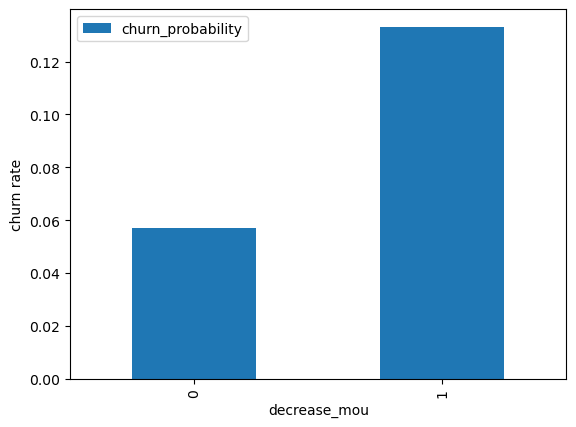

In [39]:
# Churn rate on the basis whether the customer decreased her/his MOU.
train_data.pivot_table(values='churn_probability', index='decrease_mou', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

#### We can see that the churn rate is more for the customers, whose minutes of usage(mou) decreased

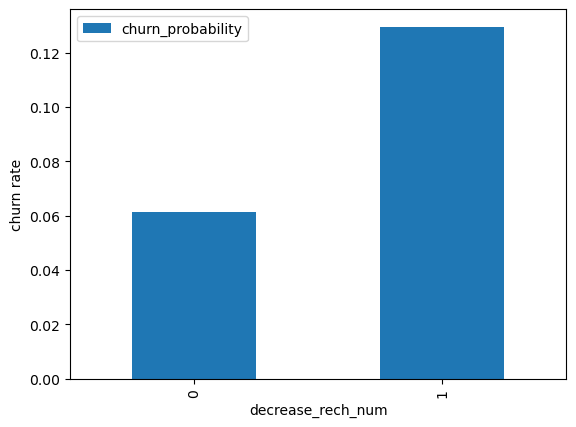

In [40]:
# Churn rate on the basis whether the customer decreased her/his number of recharge
train_data.pivot_table(values='churn_probability', index='decrease_rech_num', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

#### We can see that the churn rate is more for the customers,whose number of recharge decreased

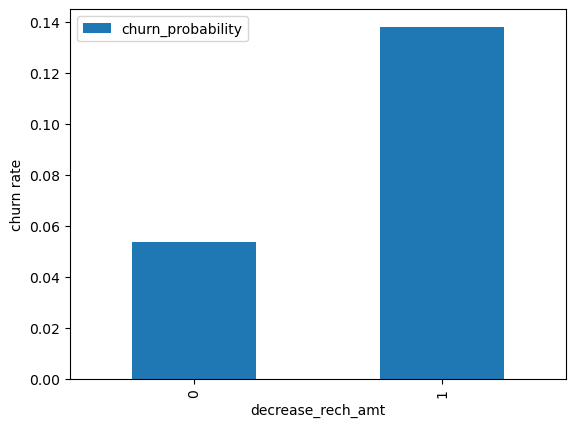

In [41]:
train_data.pivot_table(values='churn_probability', index='decrease_rech_amt', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

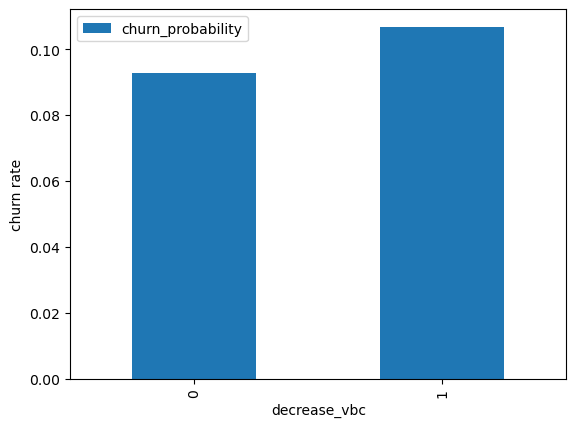

In [42]:
train_data.pivot_table(values='churn_probability', index='decrease_vbc', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

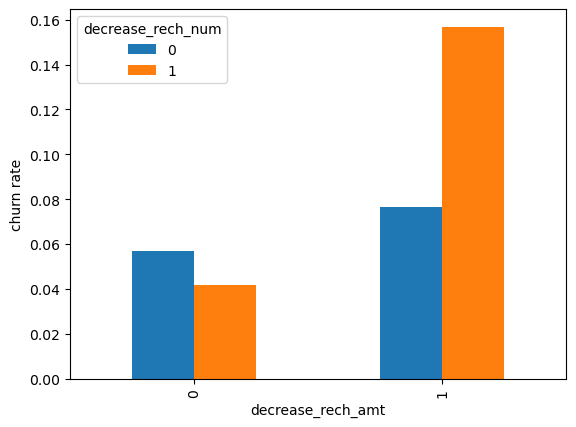

In [43]:
# Bivariate Analysis
train_data.pivot_table(values='churn_probability', index='decrease_rech_amt', columns='decrease_rech_num', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

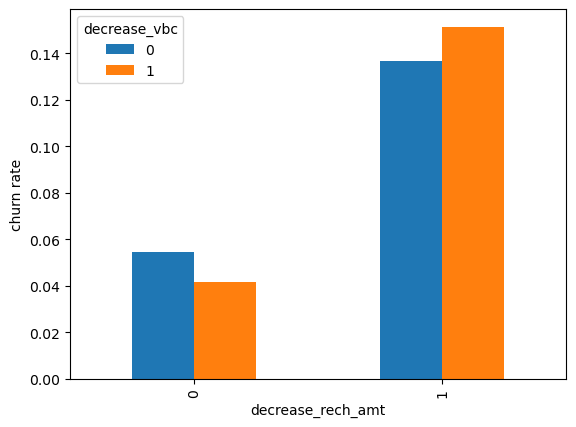

In [44]:
train_data.pivot_table(values='churn_probability', index='decrease_rech_amt', columns='decrease_vbc', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

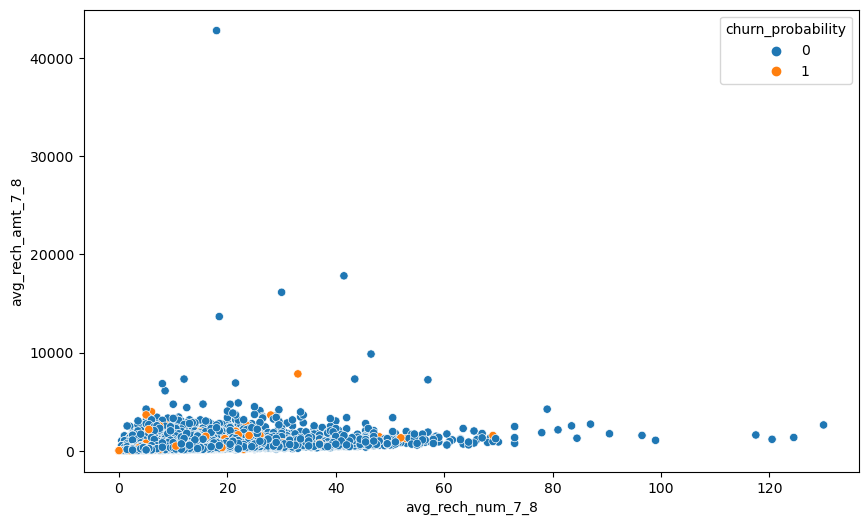

In [45]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='avg_rech_num_7_8',y='avg_rech_amt_7_8', hue='churn_probability', data=train_data)

In [46]:
# Dropping few derived columns, which are not required in further analysis
train_data = train_data.drop(['total_mou_6', 'avg_mou_7_8', 'diff_mou', 'decrease_mou', 'avg_rech_num_7_8', 'diff_rech_num', 
                  'decrease_rech_num', 'avg_rech_amt_7_8', 'diff_rech_amt', 'decrease_rech_amt', 'avg_arpu_7_8', 
                  'diff_arpu', 'decrease_arpu', 'avg_vbc_3g_7_8', 'diff_vbc', 'decrease_vbc'], axis=1)

In [47]:
train_data.shape

(55392, 111)

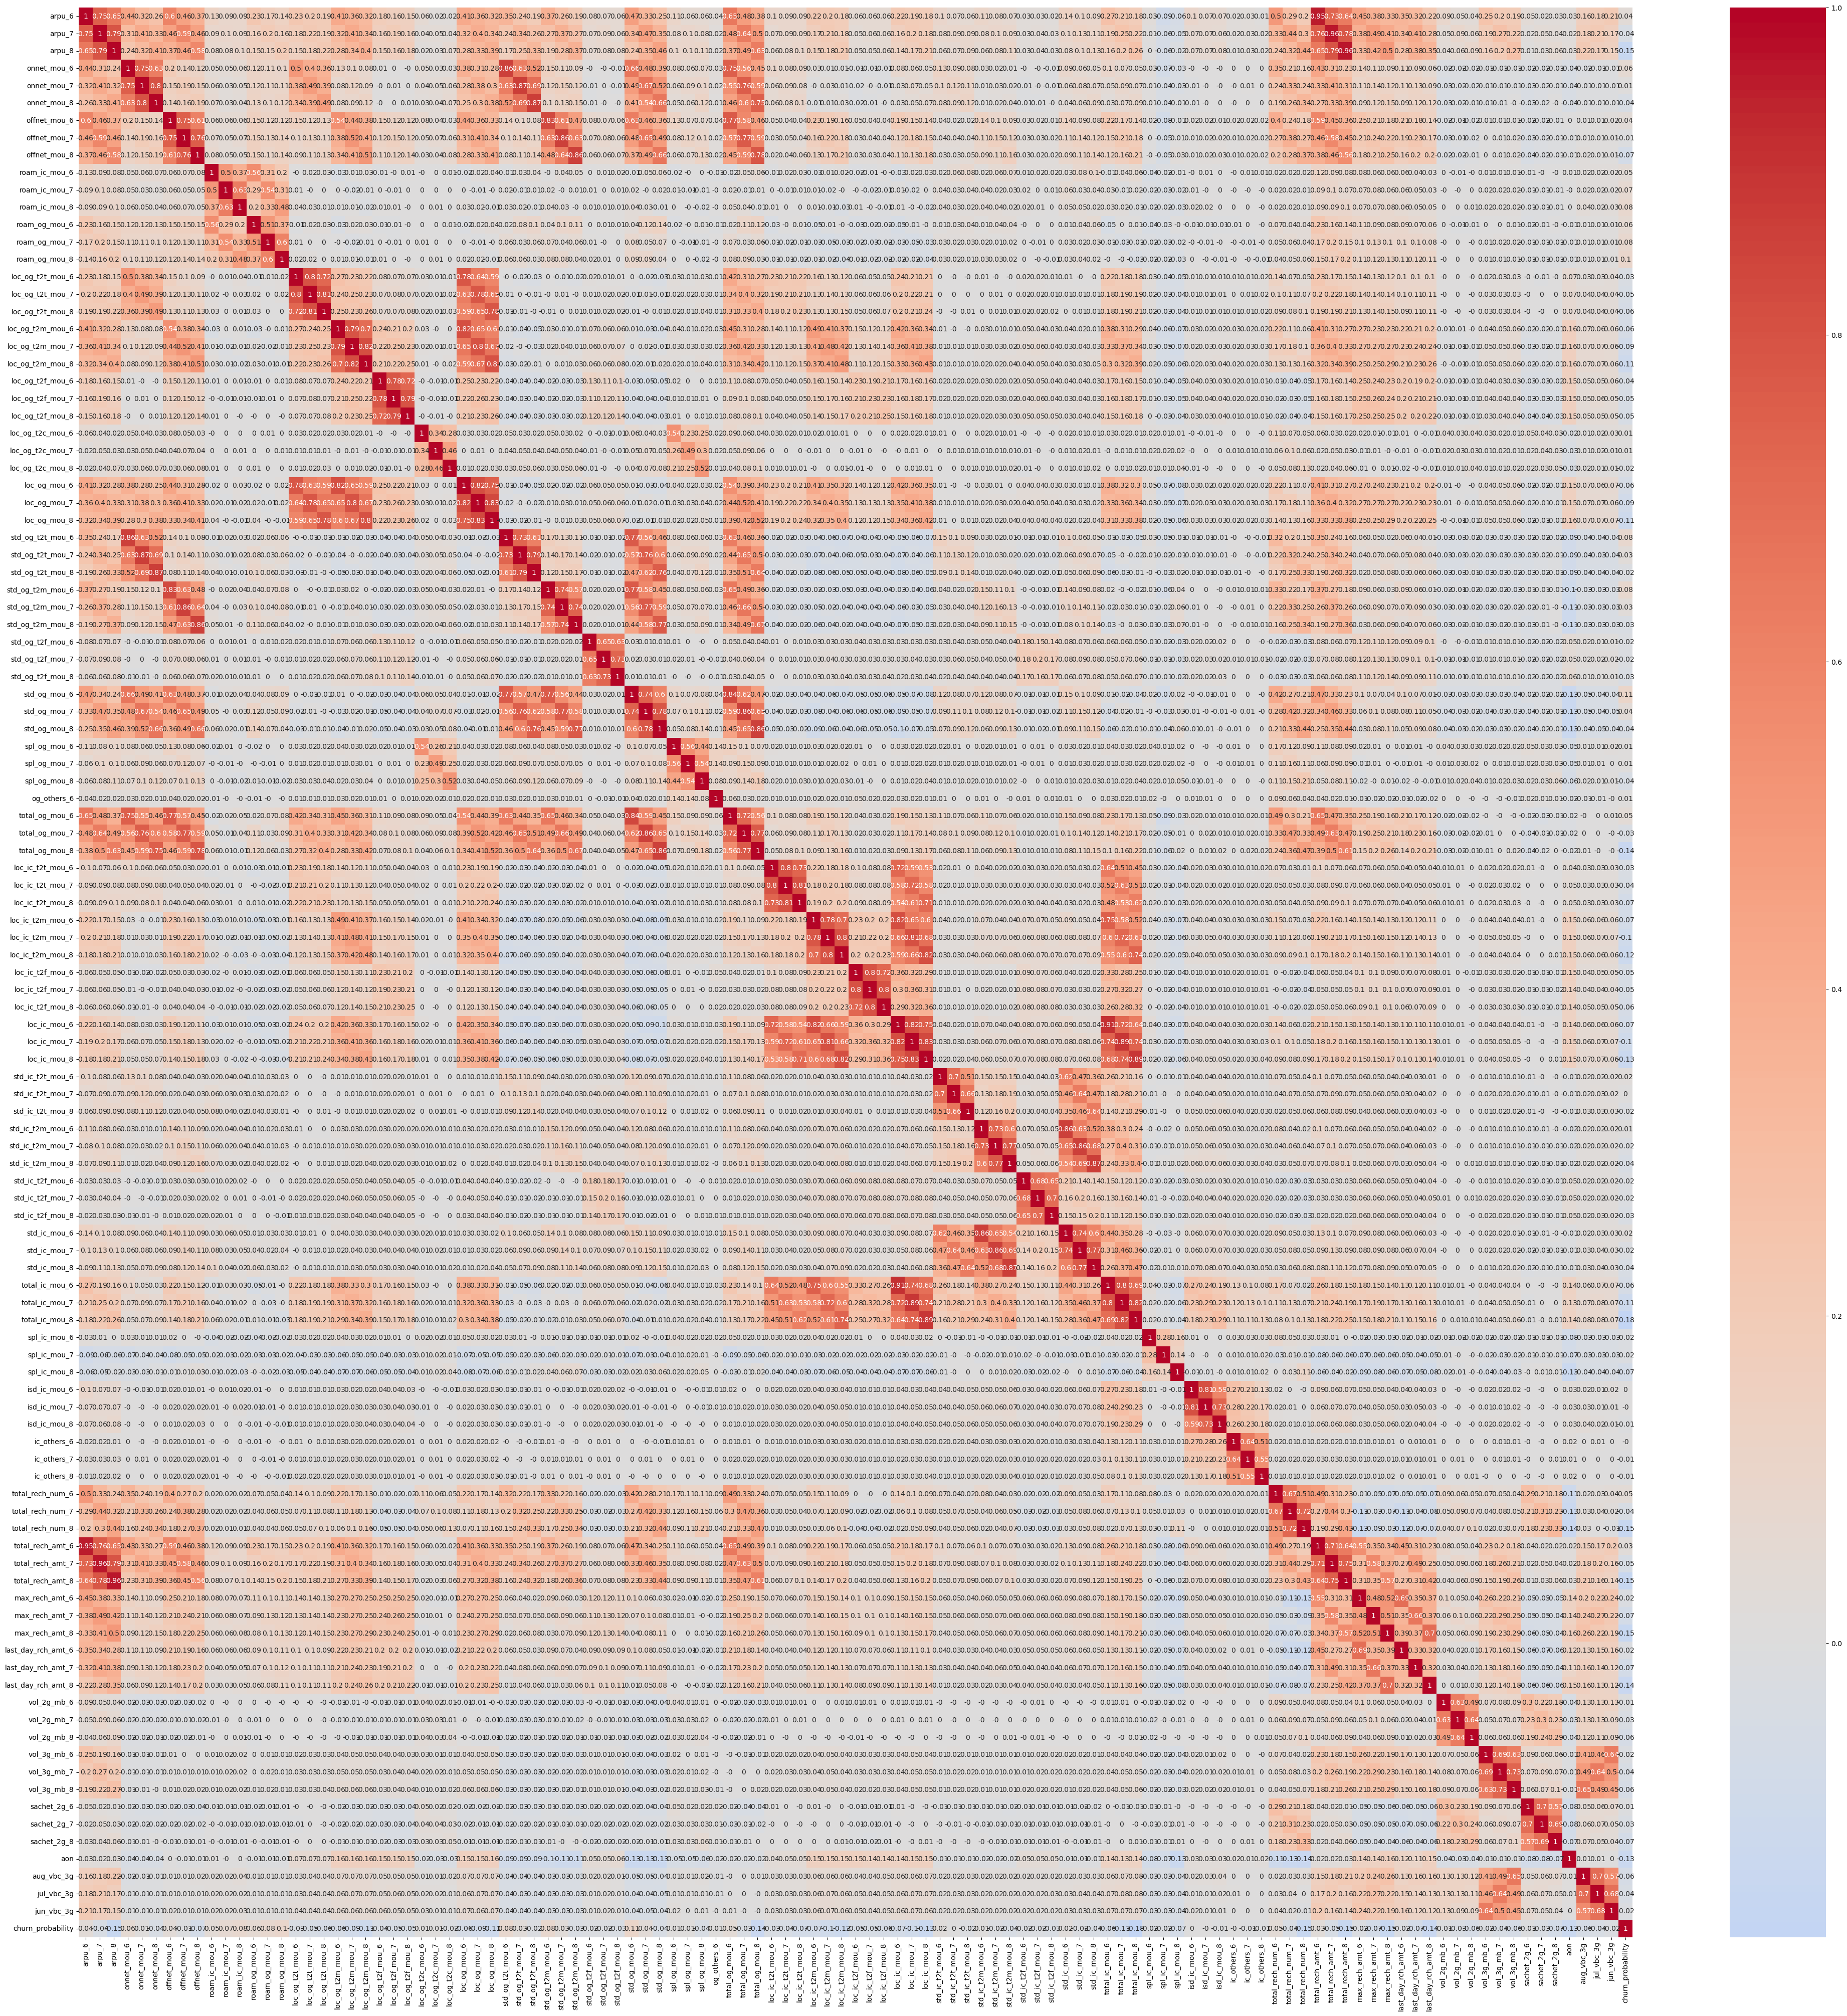

In [48]:
# Checking the corelation
plt.subplots(figsize = (50,50))
#Plotting heatmap of numerical features
sns.heatmap(round(train_data.corr(),2), cmap='coolwarm' , annot=True, center = 0)
plt.show()

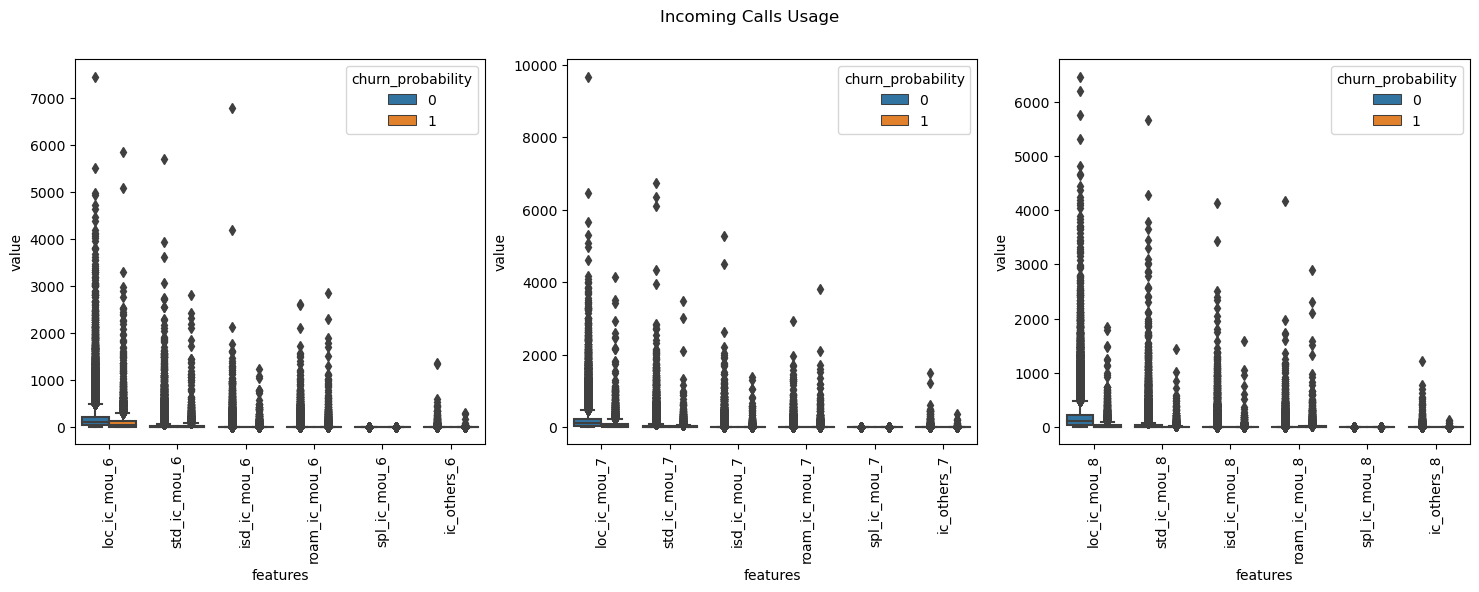

In [49]:
# Ploting the boxplot for the Incoming call usage
cols = [['loc_ic_mou_6','std_ic_mou_6','isd_ic_mou_6','roam_ic_mou_6','spl_ic_mou_6','ic_others_6'],
        ['loc_ic_mou_7','std_ic_mou_7','isd_ic_mou_7','roam_ic_mou_7','spl_ic_mou_7','ic_others_7'],
        ['loc_ic_mou_8','std_ic_mou_8','isd_ic_mou_8','roam_ic_mou_8','spl_ic_mou_8','ic_others_8']]

# plot for the incoming calls usage
plt.figure(figsize=(18, 5))
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([train_data[cols[i]], train_data['churn_probability']], axis=1)
    X = pd.melt(X,id_vars="churn_probability",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn_probability", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Incoming Calls Usage')

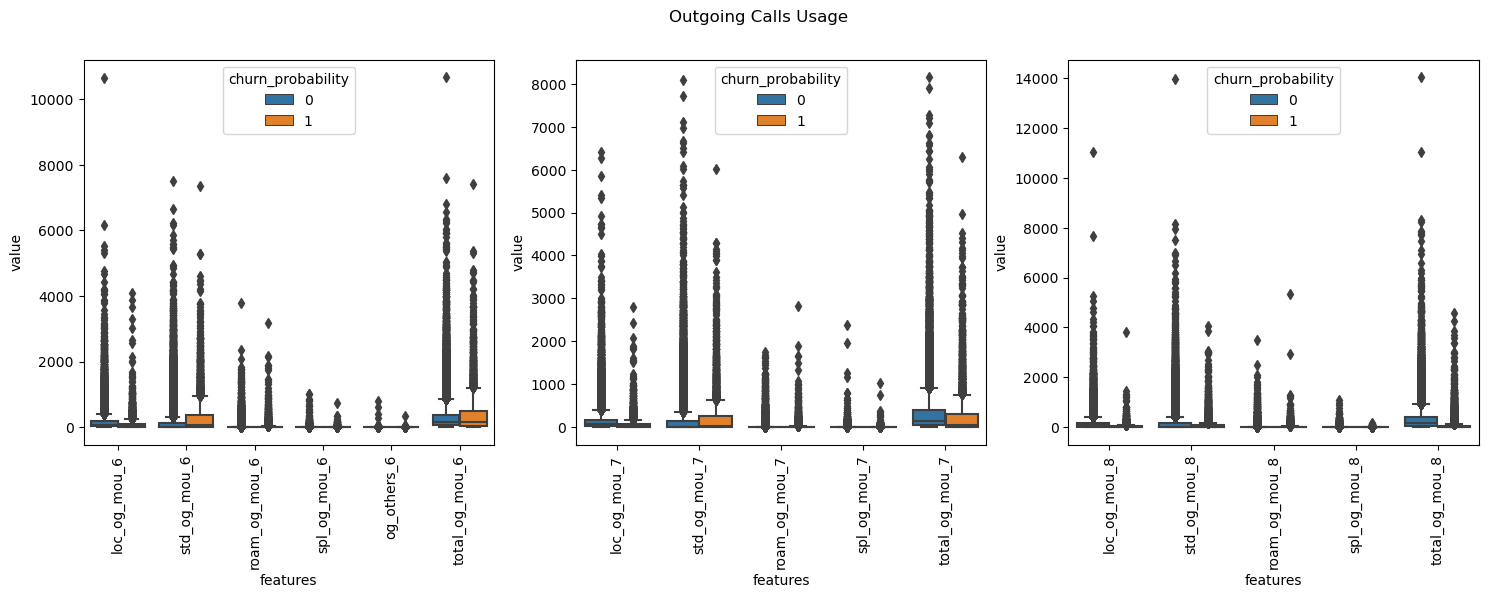

In [50]:
# Plotting the boxplot to vizualise the outgoing calls
cols = [['loc_og_mou_6','std_og_mou_6','roam_og_mou_6','spl_og_mou_6','og_others_6','total_og_mou_6'],
        ['loc_og_mou_7','std_og_mou_7','roam_og_mou_7','spl_og_mou_7','total_og_mou_7'],
        ['loc_og_mou_8','std_og_mou_8','roam_og_mou_8','spl_og_mou_8','total_og_mou_8']]


# plot for the outgoing calls usage
plt.figure(figsize=(18, 5))
#ic call usage
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([train_data[cols[i]], train_data['churn_probability']], axis=1)
    X = pd.melt(X,id_vars="churn_probability",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn_probability", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Outgoing Calls Usage')

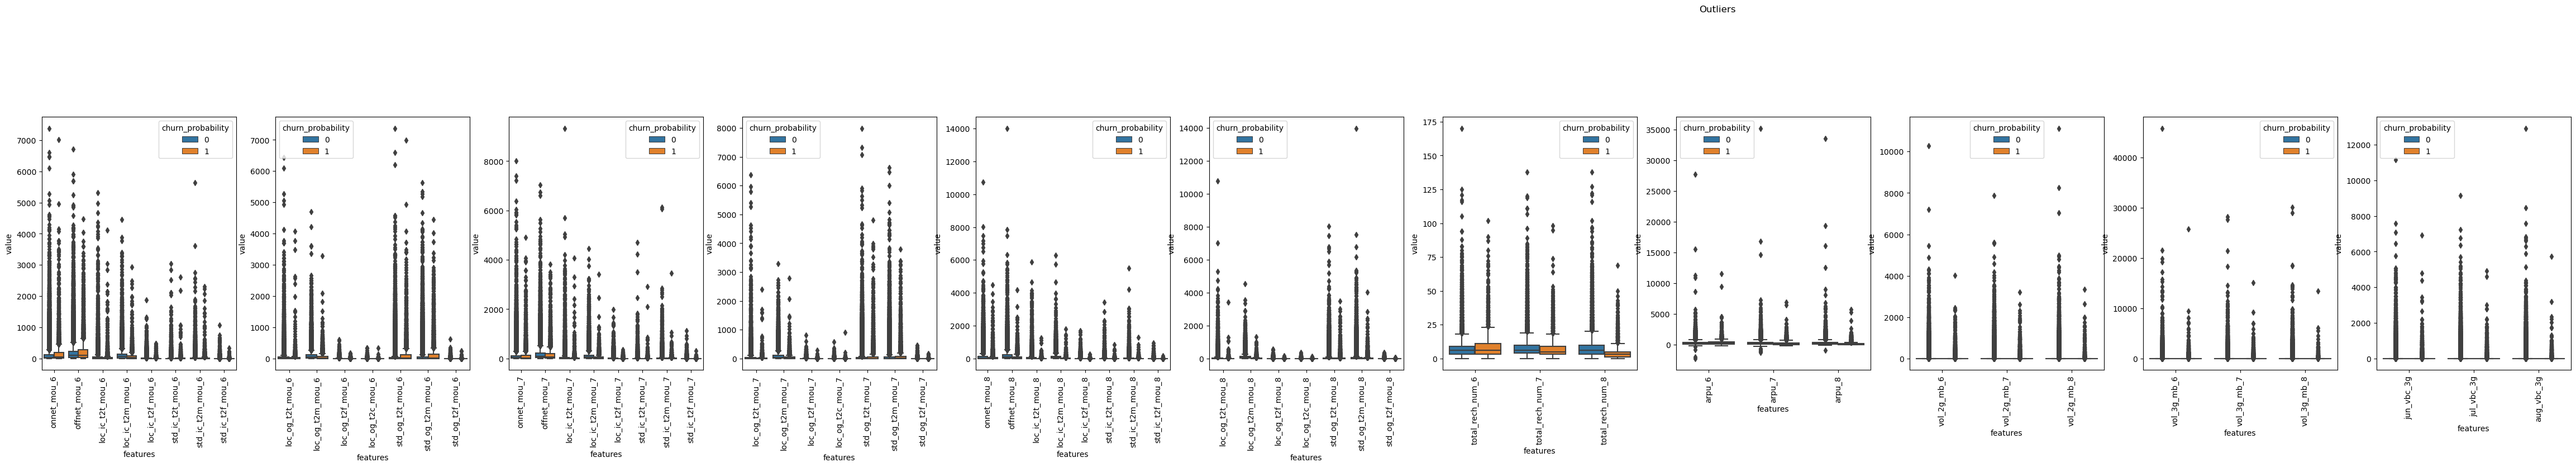

In [51]:
cols=[['onnet_mou_6','offnet_mou_6','loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6'],
        ['loc_og_t2t_mou_6','loc_og_t2m_mou_6','loc_og_t2f_mou_6','loc_og_t2c_mou_6','std_og_t2t_mou_6','std_og_t2m_mou_6','std_og_t2f_mou_6'],
        ['onnet_mou_7','offnet_mou_7','loc_ic_t2t_mou_7','loc_ic_t2m_mou_7','loc_ic_t2f_mou_7','std_ic_t2t_mou_7','std_ic_t2m_mou_7','std_ic_t2f_mou_7'],
        ['loc_og_t2t_mou_7','loc_og_t2m_mou_7','loc_og_t2f_mou_7','loc_og_t2c_mou_7','std_og_t2t_mou_7','std_og_t2m_mou_7','std_og_t2f_mou_7'],
        ['onnet_mou_8','offnet_mou_8','loc_ic_t2t_mou_8','loc_ic_t2m_mou_8','loc_ic_t2f_mou_8','std_ic_t2t_mou_8','std_ic_t2m_mou_8','std_ic_t2f_mou_8'],
        ['loc_og_t2t_mou_8','loc_og_t2m_mou_8','loc_og_t2f_mou_8','loc_og_t2c_mou_8','std_og_t2t_mou_8','std_og_t2m_mou_8','std_og_t2f_mou_8'],
        ['total_rech_num_6','total_rech_num_7','total_rech_num_8'], 
        ['arpu_6','arpu_7','arpu_8'],
        ['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8'],
        ['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'],
        ['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g']]

# plotting the box plot for cols
plt.figure(figsize=(80, 20))
#ic call usage
for i in range(0,11):
    plt.subplot(3, 15, i+1)
    X = pd.concat([train_data[cols[i]], train_data['churn_probability']], axis=1)
    X = pd.melt(X,id_vars="churn_probability",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn_probability", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Outliers')

In [54]:
# Also we have Observed during our analysis that the total columns are sum of the individual features.
# Hence Can be dropped from Train and Test Set

total_columns = [total for total in train_data.columns.to_list() if 'total' in total]
total_columns

['total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8']

In [58]:
train_data = train_data.drop(total_columns,axis=1)
train_data.shape

(55392, 99)

In [59]:
test_data = test_data.drop(total_columns,axis=1)
test_data.shape

(13849, 99)

#### We observed from Description and visualization that there are many outliers. We will handle this in feature engineering part

### Create X_train , y_train , X_test and y_test from train data and test data

In [80]:
# Putting feature variables into X
X_train = train_data.drop(['churn_probability'], axis=1)
# Putting target variable to y
y_train = train_data['churn_probability']

# Putting feature variables into X
X_test = test_data.drop(['churn_probability'], axis=1)
# Putting target variable to y
y_test = test_data['churn_probability']

In [81]:
print('X Train Data shape :',X_train.shape)
print('y Train Data shape :',y_train.shape)

print('X Test Data shape :',X_test.shape)
print('y Test Data shape :',y_test.shape)

X Train Data shape : (55392, 98)
y Train Data shape : (55392,)
X Test Data shape : (13849, 98)
y Test Data shape : (13849,)


<Axes: >

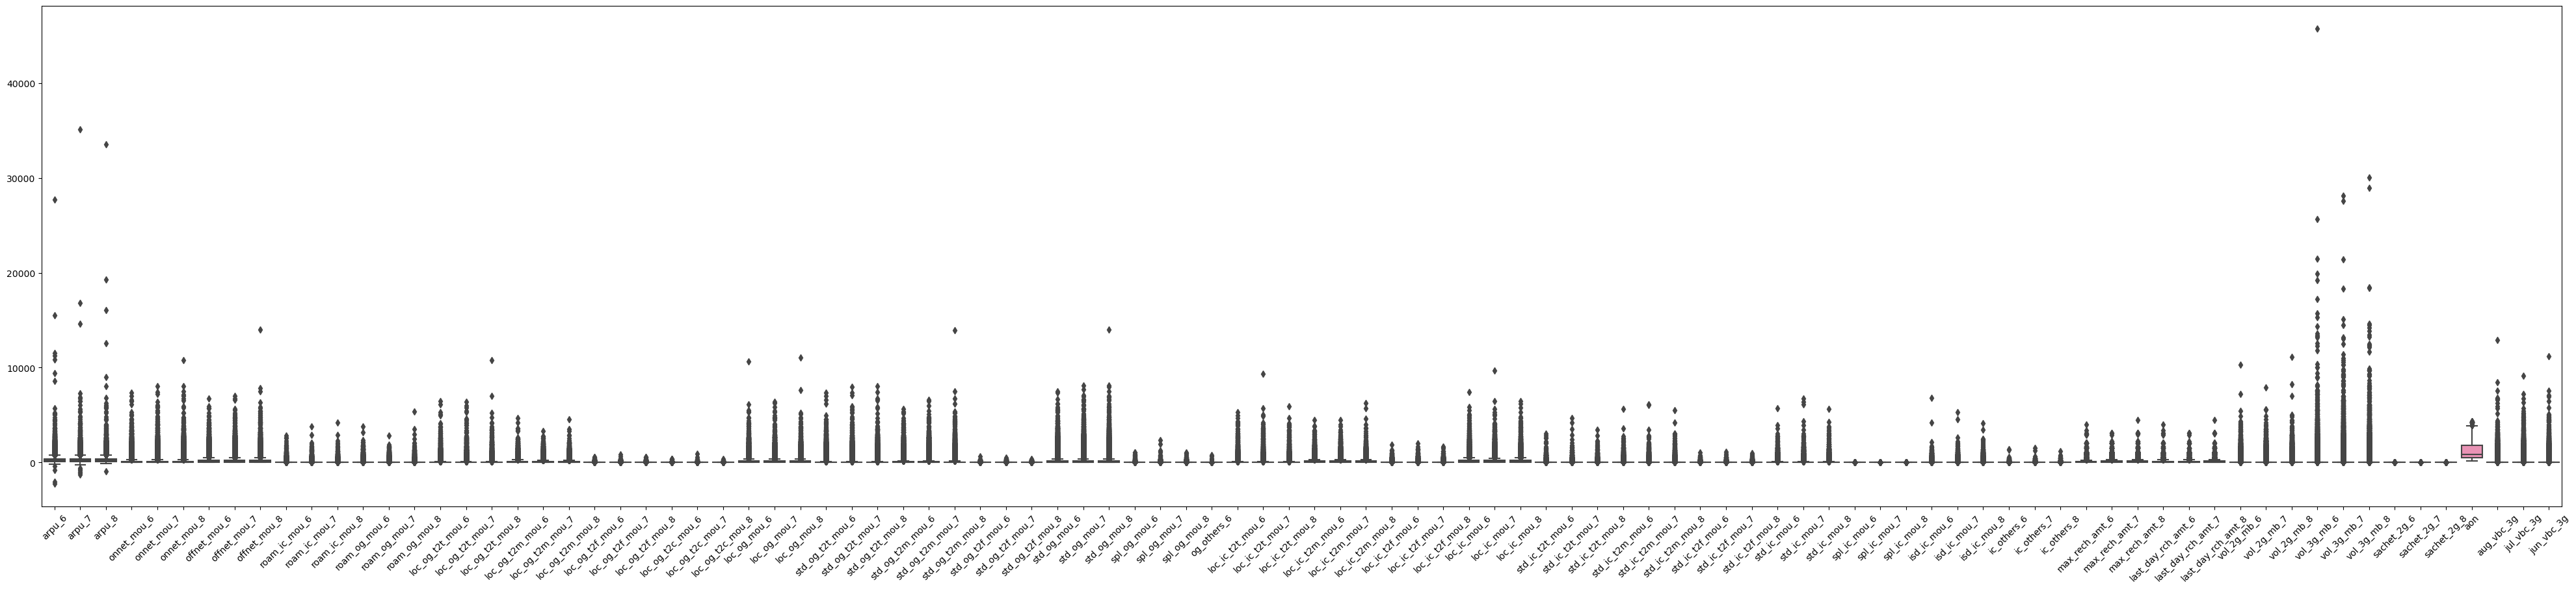

In [82]:
plt.figure(figsize=(50,10))
plt.xticks(rotation=45)
sns.boxplot(data = X_train)

In [83]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

X_train_filtered = X_train.apply(cap_outliers, axis=0)



<Axes: >

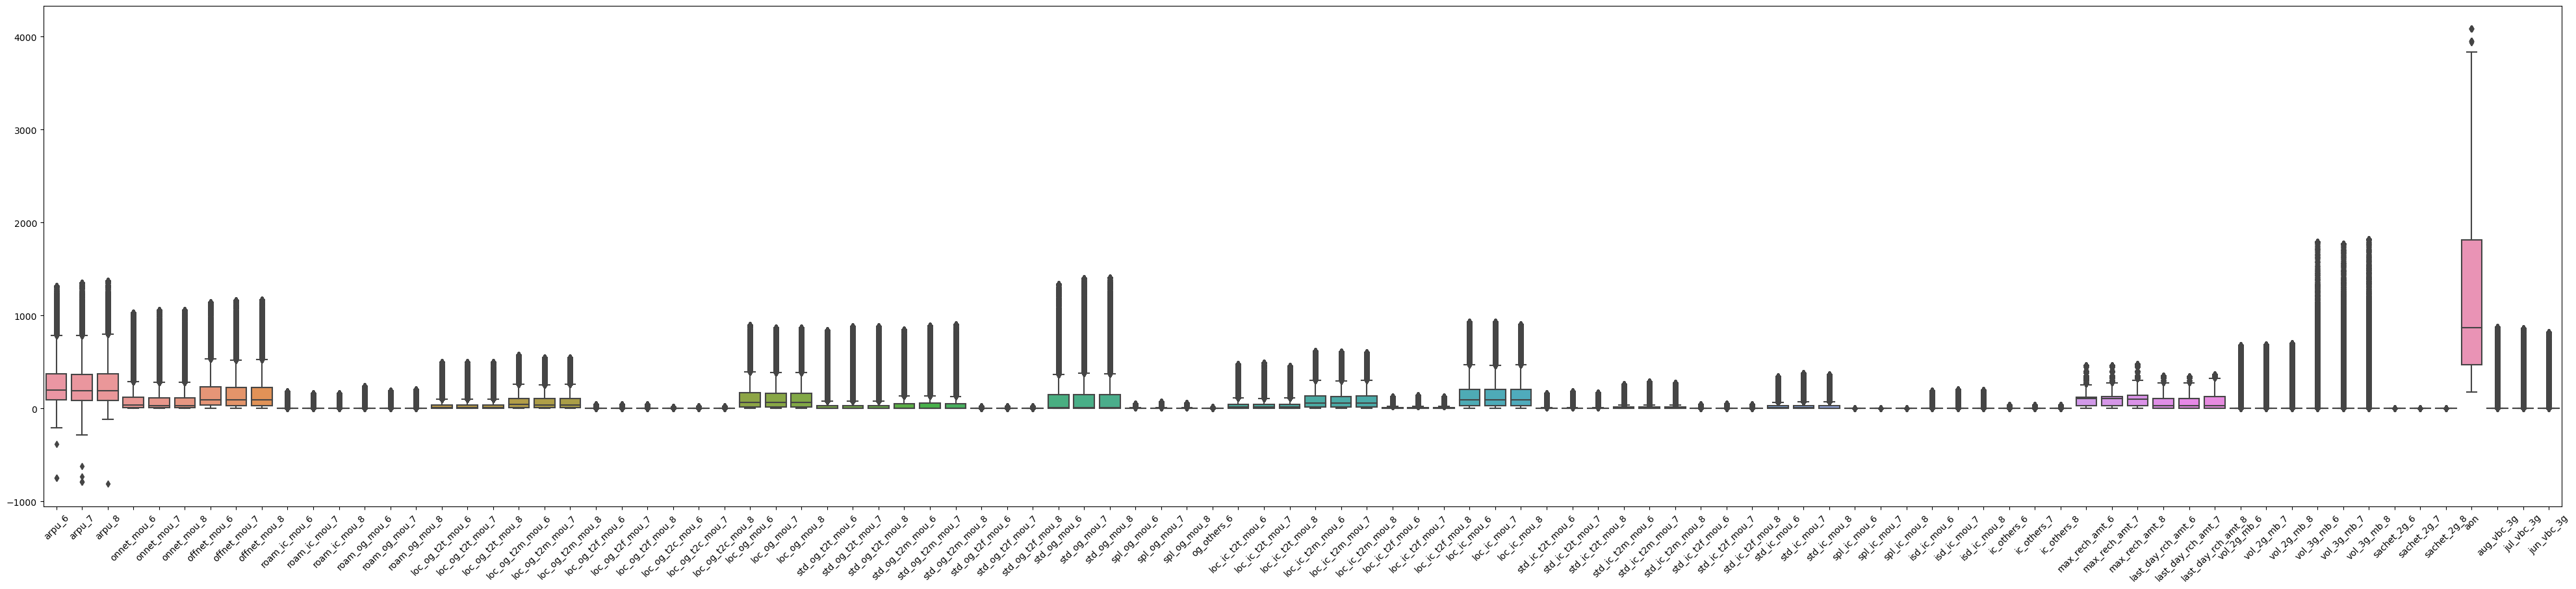

In [84]:
plt.figure(figsize=(50,10))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

In [85]:
# Cheking Again percent of missing values in columns
df_missing_columns = (round(((X_train_filtered.isnull().sum()/len(X_train_filtered.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
df_missing_columns.sort_values('null', ascending=False)

null
loc_og_mou_8      4.18
loc_ic_t2m_mou_8  4.18
std_og_t2f_mou_8  4.18
isd_ic_mou_8      4.18
roam_og_mou_8     4.18
...                ...
aon               0.00
jul_vbc_3g        0.00
aug_vbc_3g        0.00
vol_2g_mb_8       0.00
jun_vbc_3g        0.00

[98 rows x 1 columns]

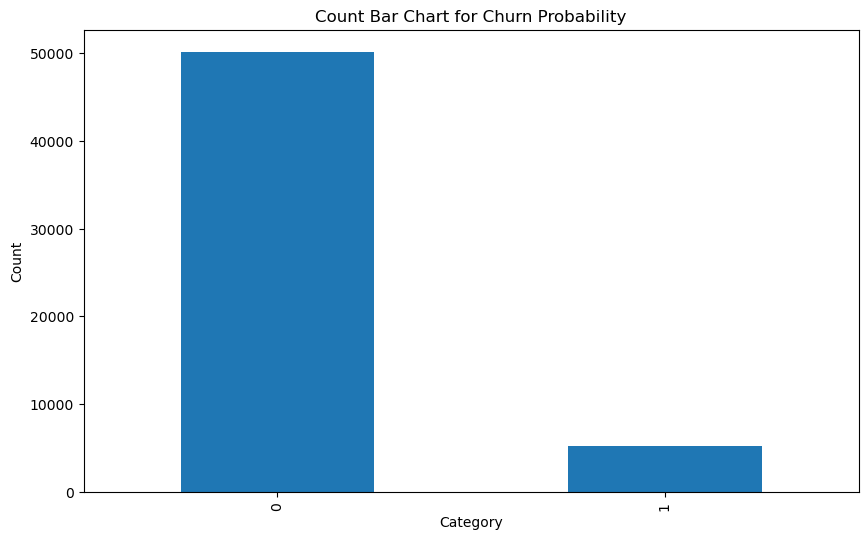

In [86]:
churn_probability_counts = y_train.value_counts()
plt.figure(figsize=(10, 6))
churn_probability_counts.plot(kind='bar')
plt.title('Count Bar Chart for Churn Probability')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [87]:
scaler = StandardScaler()
smote = SMOTE(random_state=42)
imputer = SimpleImputer(strategy='median', fill_value=0)
pca = PCA(random_state=42)

In [88]:
pipeline_pca = Pipeline(steps=[
    ('imputation', imputer),
    ('scaling', scaler),
    ('pca', pca)
])

In [89]:
pipeline_pca.fit(X_train_filtered)
principal_components = pipeline_pca.named_steps['pca'].components_
principal_components

array([[ 1.78620055e-01,  1.89097238e-01,  1.79853790e-01, ...,
         5.47777340e-02,  5.49882404e-02,  5.11777303e-02],
       [ 9.42623079e-02,  1.16110811e-01,  1.03700654e-01, ...,
        -4.60726071e-02, -4.61327511e-02, -4.49812928e-02],
       [-1.65969851e-03,  2.19153793e-03,  4.63071258e-03, ...,
         1.89868940e-01,  1.97411596e-01,  1.89042409e-01],
       ...,
       [-1.07035784e-02,  1.61362288e-02, -9.13810012e-03, ...,
         1.70995603e-03, -5.52674920e-04,  2.39925974e-04],
       [ 8.42109287e-03,  5.40676125e-03, -1.45878063e-02, ...,
        -2.49894416e-05, -6.36753265e-04,  3.45343046e-04],
       [-6.11695959e-03,  1.14804308e-02, -7.01706803e-03, ...,
        -1.94957225e-03,  1.34983791e-03,  8.34353068e-04]])

In [90]:
# Cumuliative varinace of the PCs
variance_cumu = np.cumsum(pipeline_pca.named_steps['pca'].explained_variance_ratio_)
print(variance_cumu)

[0.15274138 0.24600829 0.30163295 0.35318181 0.39248421 0.42897265
 0.46127127 0.48995975 0.51802975 0.5440686  0.56905824 0.59339429
 0.61546313 0.63464831 0.65124799 0.66633841 0.68095588 0.69422279
 0.70729599 0.71969415 0.73151982 0.74296741 0.75404775 0.76482714
 0.77441486 0.78333851 0.79195122 0.80045606 0.80866234 0.81668603
 0.82442343 0.831959   0.83923385 0.84607973 0.85282855 0.85929779
 0.86538901 0.87115328 0.87685544 0.88247778 0.88799564 0.89339633
 0.89858178 0.90317344 0.90757568 0.91180858 0.91598173 0.92004274
 0.92373327 0.9273066  0.93085516 0.93430884 0.93766326 0.94096967
 0.94425841 0.94750635 0.95073684 0.95377011 0.95670756 0.95950156
 0.96215968 0.96479298 0.96735369 0.96986511 0.97224887 0.97449712
 0.97673408 0.97892378 0.98105725 0.98303439 0.98486953 0.98650958
 0.98803467 0.98953585 0.99101533 0.9924325  0.99360492 0.99457232
 0.99551183 0.99630677 0.99688369 0.99734813 0.99777659 0.99814166
 0.99846405 0.99870511 0.9988836  0.99905509 0.99919069 0.9993

Text(0, 0.5, 'Cumulative Variance')

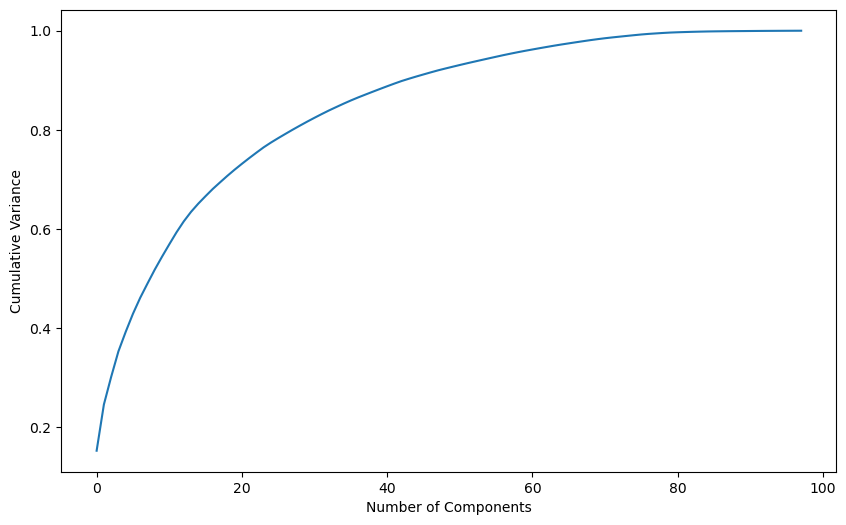

In [91]:
# Plotting scree plot
fig = plt.figure(figsize = (10,6))
plt.plot(variance_cumu)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')

We can see that 80 components explain amost more than 90% variance of the data. So, we will perform PCA with 80 components.

In [106]:
pca_final = IncrementalPCA(n_components=80)


In [107]:
## Logistic Regression with PCA
lr = LogisticRegression(max_iter=1000)

In [108]:
pipeline = Pipeline(steps=[
    ('imputation', imputer),
    ('scaling', scaler),
    ('pca', pca_final),
    ('smote', smote),
    ('model', lr)
])

In [109]:
#!pip install scikit-optimize

In [127]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [110]:


param_space = {
    'model__C': [0.01, 0.1, 1, 10, 100, 1000]
}

folds = KFold(n_splits=5, shuffle=True, random_state=4)

bayes_search = BayesSearchCV(pipeline, 
                           param_space, 
                           cv=folds, 
                           scoring='recall',
                           n_iter=50,
                           verbose=1,
                           n_jobs=-1,
                           return_train_score=True)

bayes_search.fit(X_train_filtered,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
              estimator=Pipeline(steps=[('imputation',
                                         SimpleImputer(fill_value=0,
                                                       strategy='median')),
                                        ('scaling', StandardScaler()),
                                        ('pca',
                                         IncrementalPCA(n_components=80)),
                                        ('smote', SMOTE(random_state=42)),
                                        ('model',
                                         LogisticRegression(max_iter=1000))]),
              n_jobs=-1, return_train_score=True, scoring='recall',
              search_spaces={'model__C': [0.01, 0.1, 1, 10, 100, 1000]},
              verbose=1)

In [111]:
best_pipeline = bayes_search.best_estimator_
best_pipeline

Pipeline(steps=[('imputation', SimpleImputer(fill_value=0, strategy='median')),
                ('scaling', StandardScaler()),
                ('pca', IncrementalPCA(n_components=80)),
                ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(C=1000, max_iter=1000))])

In [112]:
# Best score with best C
best_score = bayes_search.best_score_
best_C = bayes_search.best_params_['model__C']
print('Best Score : ',best_score)
print('Best C : ',best_C)

Best Score :  0.8301416849913554
Best C :  1000


In [113]:
best_pipeline = bayes_search.best_estimator_
best_pipeline

Pipeline(steps=[('imputation', SimpleImputer(fill_value=0, strategy='median')),
                ('scaling', StandardScaler()),
                ('pca', IncrementalPCA(n_components=80)),
                ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(C=1000, max_iter=1000))])

In [114]:
train_score = best_pipeline.score(X_train_filtered, y_train)
print("Training accuracy:", train_score)

test_score = best_pipeline.score(X_test, y_test)
print("Test accuracy:", test_score)

Training accuracy: 0.7901682553437319
Test accuracy: 0.786554985919561


In [115]:
confusion = confusion_matrix(y_train, best_pipeline.predict(X_train_filtered))
print(confusion)

TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives


# Accuracy
print("Accuracy: ",metrics.accuracy_score(y_train, best_pipeline.predict(X_train_filtered)))

# Sensitivity
print("Sensitivity: ",TP / float(TP+FN))

# Specificity
print("Specificity: ", TN / float(TN+FP))

[[39413 10772]
 [  851  4356]]
Accuracy:  0.7901682553437319
Sensitivity:  0.8365661609371999
Specificity:  0.7853541894988543


In [116]:
confusion = confusion_matrix(y_test, best_pipeline.predict(X_test))
print(confusion)

TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives


# Accuracy
print("Accuracy: ",metrics.accuracy_score(y_test, best_pipeline.predict(X_test)))

# Sensitivity
print("Sensitivity: ",TP / float(TP+FN))

# Specificity
print("Specificity: ", TN / float(TN+FP))

[[9740 2723]
 [ 233 1153]]
Accuracy:  0.786554985919561
Sensitivity:  0.8318903318903319
Specificity:  0.781513279306748


In [117]:
precision_score(y_test, best_pipeline.predict(X_test))

0.29747162022703816

In [118]:
recall_score(y_test,best_pipeline.predict(X_test))

0.8318903318903319

1. A higher recall score (0.831) suggests that the model is effective at identifying most of the positive cases, which is often desirable in scenarios where missing a positive instance (false negative) is more costly.
2. The lower precision score (0.315) indicates that there is room for improvement in reducing false positives. This might be acceptable depending on the application, especially if avoiding false negatives (high recall) is prioritized over precision

In [119]:
dtree = DecisionTreeClassifier()

param_space = {
    'model__max_depth': Integer(5, 15),
    'model__min_samples_leaf': Integer(50, 150),
    'model__min_samples_split': Integer(50, 150),
}

pipeline = Pipeline(steps=[
    ('imputation', imputer),
    ('scaling', scaler),
    ('pca', pca_final),
    ('smote', smote), 
    ('model', dtree)
])


bayes_search = BayesSearchCV(pipeline, 
                           param_space, 
                           cv=5, 
                           scoring='recall',
                           n_iter=50,
                           verbose=1,
                           n_jobs=-1,
                           return_train_score=True)

bayes_search.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('imputation',
                                         SimpleImputer(fill_value=0,
                                                       strategy='median')),
                                        ('scaling', StandardScaler()),
                                        ('pca',
                                         IncrementalPCA(n_components=80)),
                                        ('smote', SMOTE(random_state=42)),
                                        ('model', DecisionTreeClassifier())]),
              n_jobs=-1, return_train_score=True, scoring='recall',
              search_spaces={'model__max_depth': Integer(low=5, high=15, prior='uniform', transform='normalize'),
                             'model__min_samples_leaf': Integer(low=50, high=150, prior='uniform', transform='normalize'),
                             'model__min_samples_split': Integer(low=50, high=150, prior='uniform', transform='normalize')},
              verbose=1)

In [120]:
best_pipeline = bayes_search.best_estimator_
best_pipeline

Pipeline(steps=[('imputation', SimpleImputer(fill_value=0, strategy='median')),
                ('scaling', StandardScaler()),
                ('pca', IncrementalPCA(n_components=80)),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=50,
                                        min_samples_split=68))])

In [121]:
train_score = best_pipeline.score(X_train_filtered, y_train)
print("Training accuracy:", train_score)

test_score = best_pipeline.score(X_test, y_test)
print("Test accuracy:", test_score)

Training accuracy: 0.7990142980935875
Test accuracy: 0.7856884973644307


In [122]:
confusion = confusion_matrix(y_train, best_pipeline.predict(X_train_filtered))
print(confusion)

TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives


# Accuracy
print("Accuracy: ",metrics.accuracy_score(y_train, best_pipeline.predict(X_train_filtered)))

# Sensitivity
print("Sensitivity: ",TP / float(TP+FN))

# Specificity
print("Specificity: ", TN / float(TN+FP))

[[40246  9939]
 [ 1194  4013]]
Accuracy:  0.7990142980935875
Sensitivity:  0.7706932974841559
Specificity:  0.8019527747334861


In [123]:
confusion = confusion_matrix(y_test, best_pipeline.predict(X_test))
print(confusion)

TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives


# Accuracy
print("Accuracy: ",metrics.accuracy_score(y_test, best_pipeline.predict(X_test)))

# Sensitivity
print("Sensitivity: ",TP / float(TP+FN))

# Specificity
print("Specificity: ", TN / float(TN+FP))

[[9847 2616]
 [ 352 1034]]
Accuracy:  0.7856884973644307
Sensitivity:  0.746031746031746
Specificity:  0.790098692128701


In [124]:
precision_score(y_test, best_pipeline.predict(X_test))

0.28328767123287674

In [125]:
recall_score(y_test,best_pipeline.predict(X_test))

0.746031746031746

In [ ]:
# Create a based model
rf = RandomForestClassifier()

param_dist = {
    'model__max_depth': Integer(5, 10),  # Range for max_depth
    'model__min_samples_leaf': Integer(50, 150),  # Range for min_samples_leaf
    'model__min_samples_split': Integer(50, 150),  # Range for min_samples_split
    'model__n_estimators': Integer(100, 300),  # Range for n_estimators
    'model__max_features': Categorical([10, 20])  # Specific values for max_features
}

# Instantiate the pipeline with your preprocessing steps and model
pipeline = Pipeline(steps=[
    ('imputation', imputer),
    ('scaling', scaler),
    ('pca', pca_final),
    ('smote', smote), 
    ('model', rf)
])

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(
    pipeline,
    param_dist,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    n_iter=50,  # Number of iterations for Bayesian optimization
    verbose=1,
    random_state=42
)

# Fit the BayesSearchCV model
bayes_search.fit(X_train_filtered, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
best_pipeline = bayes_search.best_estimator_
best_pipeline

In [ ]:
train_score = best_pipeline.score(X_train_filtered, y_train)
print("Training accuracy:", train_score)

test_score = best_pipeline.score(X_test, y_test)
print("Test accuracy:", test_score)

In [ ]:
confusion = confusion_matrix(y_train, best_pipeline.predict(X_train_filtered))
print(confusion)

TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives


# Accuracy
print("Accuracy: ",metrics.accuracy_score(y_train, best_pipeline.predict(X_train_filtered)))

# Sensitivity
print("Sensitivity: ",TP / float(TP+FN))

# Specificity
print("Specificity: ", TN / float(TN+FP))

In [ ]:
confusion = confusion_matrix(y_test, best_pipeline.predict(X_test))
print(confusion)

TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives


# Accuracy
print("Accuracy: ",metrics.accuracy_score(y_test, best_pipeline.predict(X_test)))

# Sensitivity
print("Sensitivity: ",TP / float(TP+FN))

# Specificity
print("Specificity: ", TN / float(TN+FP))

In [ ]:
precision_score(y_test, best_pipeline.predict(X_test))

In [ ]:
recall_score(y_test,best_pipeline.predict(X_test))